In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


Mounted at /content/drive


In [ ]:
# Path to the dataset in Google Drive
data_dir = '/content/drive/MyDrive/NN/dataset'

# Define ImageDataGenerators for training, validation, and test sets
# Data augmentation for training: rotation, zoom, and flip
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    shear_range=0.2,  # Randomly apply shear transformations
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Randomly flip images horizontally
    validation_split=0.15  # 85% train, 15% validation from 90% of the dataset
)

# Test set does not require augmentation, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Training generator (70% of the data)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resize images to 224x224, the input size for EfficientNetB0
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    subset='training'  # 85% of 90% for training
)

# Validation generator (15% of the data)
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # 15% of 90% for validation
)

# Test set (15% of the data)
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No shuffling for test data
)

Found 3586 images belonging to 4 classes.
Found 631 images belonging to 4 classes.
Found 4217 images belonging to 4 classes.


In [ ]:
# Load EfficientNetB0 model pre-trained on ImageNet, without the top layer (include_top=False)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for our 4-class problem
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling instead of flattening
x = Dense(1024, activation='relu')(x)  # Fully connected layer with ReLU activation
predictions = Dense(4, activation='softmax')(x)  # Output layer for 4 classes with softmax

# Create the final model by combining the base and custom layers
model = Model(inputs=base_model.input, outputs=predictions)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile the model with Adam optimizer and a low learning rate for transfer learning
model.compile(optimizer=Adam(learning_rate=0.0001),  # Low learning rate for fine-tuning
              loss='categorical_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy'])  # Track accuracy as the metric


In [ ]:
# Train the model without early stopping
history = model.fit(
    train_generator,  # Training data generator
    epochs=15,  # Number of epochs
    validation_data=validation_generator,  # Validation data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Steps per epoch
    validation_steps=validation_generator.samples // validation_generator.batch_size  # Validation steps
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 1274s 10s/step - accuracy: 0.6593 - loss: 0.8598 - val_accuracy: 0.2648 - val_loss: 1.3852
Epoch 2/15
  1/112 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.9375 - loss: 0.3062

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.9375 - loss: 0.3062 - val_accuracy: 0.2609 - val_loss: 1.3853
Epoch 3/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 119s 755ms/step - accuracy: 0.8846 - loss: 0.3046 - val_accuracy: 0.3109 - val_loss: 1.4053
Epoch 4/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.1046 - val_accuracy: 0.2174 - val_loss: 1.4844
Epoch 5/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 142s 756ms/step - accuracy: 0.9226 - loss: 0.2147 - val_accuracy: 0.2401 - val_loss: 1.8892
Epoch 6/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0506 - val_accuracy: 0.3478 - val_loss: 1.7495
Epoch 7/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 141s 741ms/step - accuracy: 0.9294 - loss: 0.1775 - val_accuracy: 0.3914 - val_loss: 1.5705
Epoch 8/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.9375 - loss: 0.1500 - val_accuracy: 0.3478 - val_loss: 1.5882
Epoch 9/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 89s 745ms/step - accuracy: 0.9487 - loss: 0.1387 - val_acc

In [ ]:
# Evaluate the model on the test set and print test accuracy
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - accuracy: 0.9408 - loss: 0.1863
Test Accuracy: 94.11%


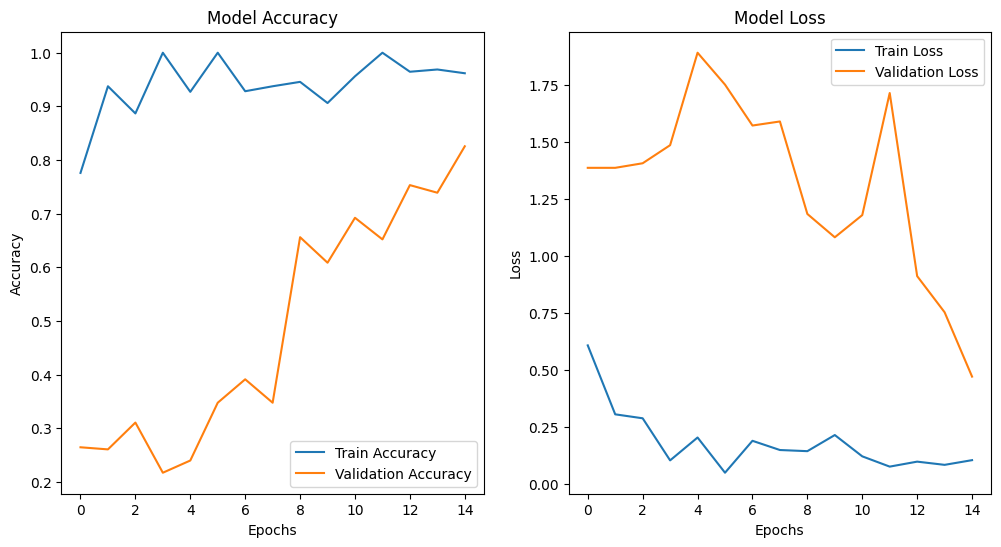

In [ ]:
# Plot training and validation accuracy and loss curves
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Predict on the test data
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)  # Convert predicted probabilities to class labels

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class names

# Generate classification report for Precision, Recall, F1-score, and Support
print('Classification Report:')
print(classification_report(true_classes, y_pred, target_names=class_labels))

# Generate confusion matrix for additional insights
print('Confusion Matrix:')
print(confusion_matrix(true_classes, y_pred))

132/132 ━━━━━━━━━━━━━━━━━━━━ 53s 362ms/step
Classification Report:
                      precision    recall  f1-score   support

            cataract       0.97      0.96      0.96      1038
diabetic_retinopathy       0.95      1.00      0.97      1098
            glaucoma       0.97      0.87      0.92      1007
              normal       0.89      0.92      0.91      1074

            accuracy                           0.94      4217
           macro avg       0.94      0.94      0.94      4217
        weighted avg       0.94      0.94      0.94      4217

Confusion Matrix:
[[ 999    7    4   28]
 [   0 1097    0    1]
 [  19   14  880   94]
 [  16   41   25  992]]
